# Prediccion de Series Temporales

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import joblib


In [3]:
df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv')
print(df.columns.tolist())

df.head()

['date', 'sales']


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [5]:

# Renombrar la columna manualmente (por si trae espacios)
df = df.rename(columns={'date': 'fecha', 'sales': 'ventas'})

#Usar fecha como índice

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')  # convierte, NaT si falla
df = df.dropna(subset=['fecha'])  # elimina filas con fecha inválida
df = df.dropna(subset=['ventas'])

#df['fecha'] = pd.to_datetime(df['fecha'])  # convertir fecha a datetime  
df = df.set_index('fecha')

print(df.index) # para comprobar que es formato fecha 
print(type(df.index))

df.head()




DatetimeIndex(['2022-09-03 17:10:08.079328', '2022-09-04 17:10:08.079328',
               '2022-09-05 17:10:08.079328', '2022-09-06 17:10:08.079328',
               '2022-09-07 17:10:08.079328', '2022-09-08 17:10:08.079328',
               '2022-09-09 17:10:08.079328', '2022-09-10 17:10:08.079328',
               '2022-09-11 17:10:08.079328', '2022-09-12 17:10:08.079328',
               ...
               '2023-08-25 17:10:08.079328', '2023-08-26 17:10:08.079328',
               '2023-08-27 17:10:08.079328', '2023-08-28 17:10:08.079328',
               '2023-08-29 17:10:08.079328', '2023-08-30 17:10:08.079328',
               '2023-08-31 17:10:08.079328', '2023-09-01 17:10:08.079328',
               '2023-09-02 17:10:08.079328', '2023-09-03 17:10:08.079328'],
              dtype='datetime64[ns]', name='fecha', length=366, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,ventas
fecha,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


Normalizar Fecha Index

In [6]:
# Normalizar índice a medianoche (sin horas)
df.index = df.index.normalize()
df.head()

,ventas
fecha,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


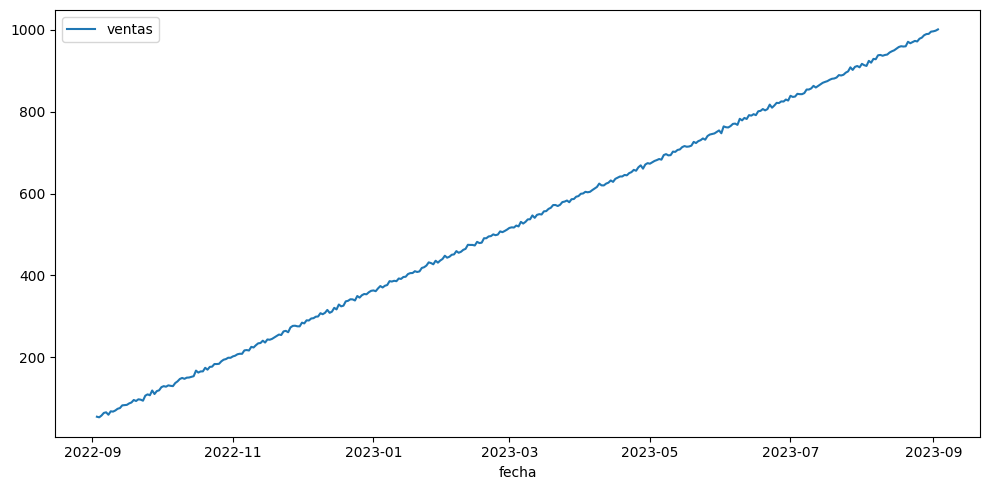

In [126]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)

plt.tight_layout()

plt.show()

Tendencia: ascendente.

Estacionalidad: No es tan visible

Variabilidad: se ve baja 

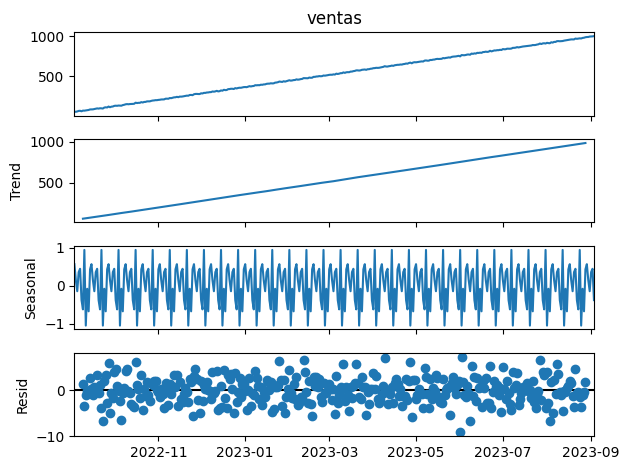

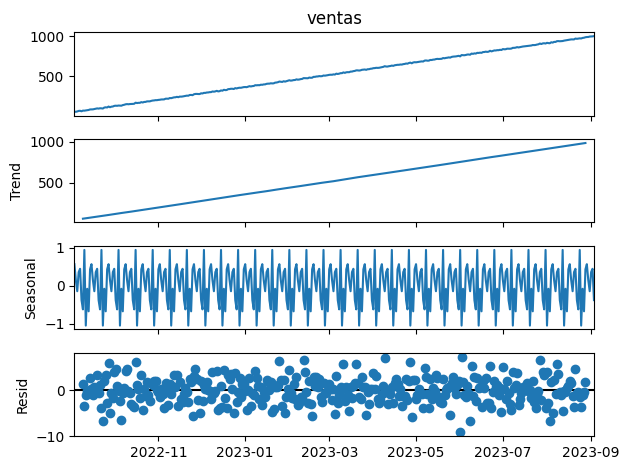

In [127]:
#Descomponer solo la columna numérica

result = seasonal_decompose(df['ventas'], period=12)

trend = result.trend
seasonal = result.seasonal
resid = result.resid

result.plot()

Analisis de Tendencia

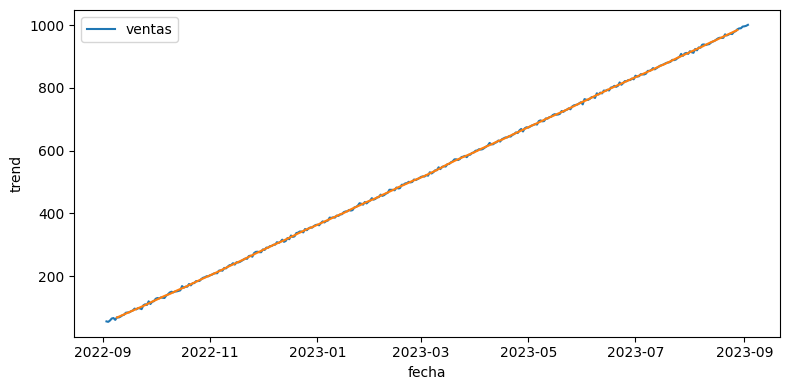

In [128]:
trend = result.trend

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

La tendencia es ascendente 

Analisis de Estacionalidad

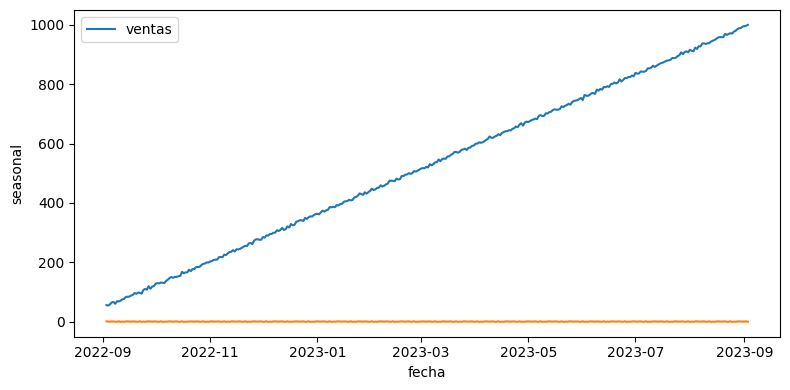

In [129]:
seasonal = result.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df) # Representa las ventas mensuales
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

No se observa estacionalidad

Prueba de Dickey - Fuller

In [130]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [131]:
test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

P- Value es mayor a 0.05 por lo que se rechaza la hipesis nula. Es decir, la serie no es estacionaria.

Variabilidad y Presencia de Ruido 

count    354.000000
mean      -0.013222
std        2.781950
min       -9.228804
25%       -1.867093
50%        0.087437
75%        1.835820
max        7.304503
Name: resid, dtype: float64


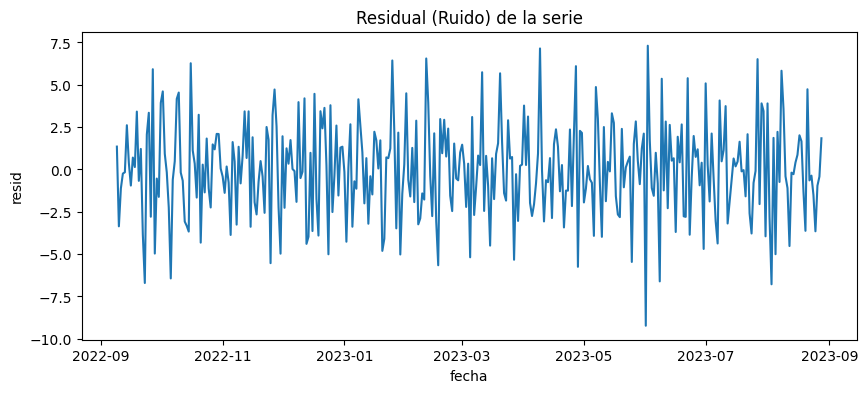

In [132]:
resid = result.resid

# Estadísticas básicas
print(resid.describe())

# Graficar residuo
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(x=resid.index, y=resid)
plt.title('Residual (Ruido) de la serie')
plt.show()

In [133]:
import numpy as np

std_resid = np.std(resid)
print(f"Desviación estándar del residuo: {std_resid:.2f}")

Desviación estándar del residuo: 2.78


La serie tiene mucho ruido, hay mucha variabibilidad alrededor del 0. Ademeas la desviación estándar es ditante a la media.

Tensores - minimo y maximo 

In [134]:
#Tensor Ventas

# Calcular estadísticas básicas
min_val = df['ventas'].min()
max_val = df['ventas'].max()
mean_val = df['ventas'].mean()

print(f"Valor mínimo: {min_val}")
print(f"Valor máximo: {max_val}")
print(f"Promedio: {mean_val}")

# Convertir cada estadística en tensor

# Tensor 0D (escalar)
tensor_min_0d = np.array(min_val)
tensor_max_0d = np.array(max_val)
tensor_mean_0d = np.array(mean_val)

# Tensor 1D (vector)
tensor_min_1d = np.array([min_val])
tensor_max_1d = np.array([max_val])
tensor_mean_1d = np.array([mean_val])

# Tensor 2D (matriz)
tensor_min_2d = np.array([[min_val]])
tensor_max_2d = np.array([[max_val]])
tensor_mean_2d = np.array([[mean_val]])

# Mostrar dimensiones y contenido
print("\n--- Tensores ---")
print(f"Min 0D: {tensor_min_0d}, ndim: {tensor_min_0d.ndim}")
print(f"Min 1D: {tensor_min_1d}, shape: {tensor_min_1d.shape}")
print(f"Min 2D: {tensor_min_2d}, shape: {tensor_min_2d.shape}")



Valor mínimo: 53.803211351129065
Valor máximo: 1000.4827845048948
Promedio: 524.963967941629

--- Tensores ---
Min 0D: 53.803211351129065, ndim: 0
Min 1D: [53.80321135], shape: (1,)
Min 2D: [[53.80321135]], shape: (1, 1)


In [135]:
#Tensor fecha

# Supongamos que tu df ya tiene 'fecha' como índice
df = df.reset_index()  # sacamos de índice temporalmente
df['fecha'] = pd.to_datetime(df['fecha'])

# Convertimos fecha a número (yyyymmdd)
df['fecha_num'] = df['fecha'].dt.strftime('%Y%m%d').astype(int)

# Creamos el tensor 1D de fechas
tensor_fecha = np.array(df['fecha_num'])
print("Tensor 1D de fechas:")
print(tensor_fecha)
print("Dimensiones:", tensor_fecha.ndim)
print("Forma:", tensor_fecha.shape)

# Opcional: tensor 2D (columna)
tensor_fecha_2d = tensor_fecha.reshape(-1, 1)
print("\nTensor 2D de fechas:")
print(tensor_fecha_2d.shape)


Tensor 1D de fechas:
[20220903 20220904 20220905 20220906 20220907 20220908 20220909 20220910
 20220911 20220912 20220913 20220914 20220915 20220916 20220917 20220918
 20220919 20220920 20220921 20220922 20220923 20220924 20220925 20220926
 20220927 20220928 20220929 20220930 20221001 20221002 20221003 20221004
 20221005 20221006 20221007 20221008 20221009 20221010 20221011 20221012
 20221013 20221014 20221015 20221016 20221017 20221018 20221019 20221020
 20221021 20221022 20221023 20221024 20221025 20221026 20221027 20221028
 20221029 20221030 20221031 20221101 20221102 20221103 20221104 20221105
 20221106 20221107 20221108 20221109 20221110 20221111 20221112 20221113
 20221114 20221115 20221116 20221117 20221118 20221119 20221120 20221121
 20221122 20221123 20221124 20221125 20221126 20221127 20221128 20221129
 20221130 20221201 20221202 20221203 20221204 20221205 20221206 20221207
 20221208 20221209 20221210 20221211 20221212 20221213 20221214 20221215
 20221216 20221217 20221218 20

Se ha calculado los tensores para proyecciones LSTM - es una Red Neuronal para secuenica de datos, series temporales, etc

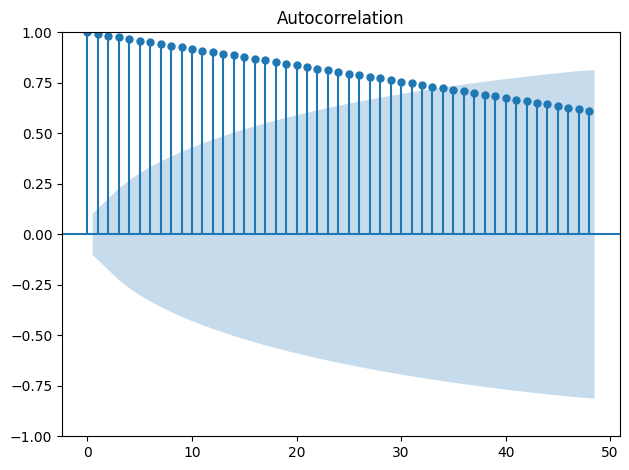

In [136]:
# Autocorrelacion

plot_acf(df['ventas'], lags=48)  # 48 lags ≈ 48 días o meses según tu frecuencia
plt.tight_layout()
plt.show()

El grafico muestra una alt correlación entre los puntos y las copias retrasadas. Es decir los valores estan relacionados con los valores pasados,

Modelo ARIMA - Prediccion 

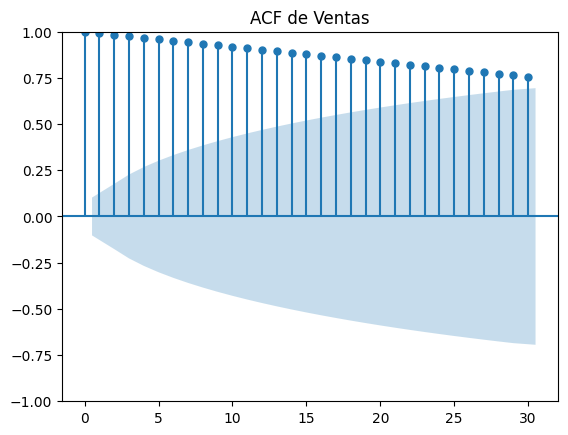

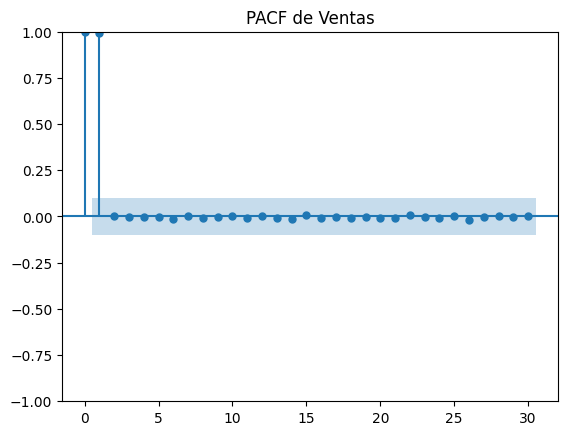

                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.230
Date:                Wed, 19 Nov 2025   AIC                           2104.459
Time:                        20:22:42   BIC                           2116.159
Sample:                             0   HQIC                          2109.109
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    637.971      0.000       0.997       1.003
ma.L1         -0.9993      0.819     -1.220      0.223      -2.605       0.607
sigma2        18.1498     14.910      1.217      0.2

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


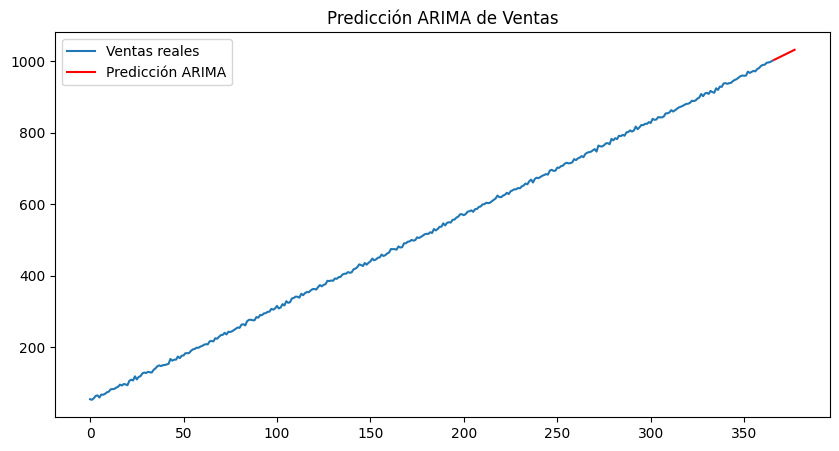

In [137]:

# df tiene 'fecha' como índice y 'ventas' como columna
df['ventas'] = df['ventas'].astype(float)

# Grafico de ACF y PACF
plot_acf(df['ventas'], lags=30)
plt.title("ACF de Ventas")
plt.show()

plot_pacf(df['ventas'], lags=30)
plt.title("PACF de Ventas")
plt.show()

# --- Ajustar modelo ARIMA ---
# Parámetros (p,d,q)
# p: lag AR (auto-regresivo)
# d: diferencias para estacionarizar
# q: lag MA (media móvil)
p, d, q = 1, 1, 1  # se ajusta según ACF/PACF

model = ARIMA(df['ventas'], order=(p,d,q))
model_fit = model.fit()

#  Resumen del modelo
print(model_fit.summary())

# PREDICCION 
start = len(df)
end = start + 11  # predecir próximos 12 periodos
forecast = model_fit.predict(start=start, end=end, typ='levels')

# Grafico
plt.figure(figsize=(10,5))
plt.plot(df['ventas'], label='Ventas reales')
plt.plot(forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción ARIMA de Ventas')
plt.legend()
plt.show()

El modelo anterior indica un ARIMA con parametros 1,1,1

ARIMA AUTOMATICO

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.125, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.695, Time=0.91 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.36 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.437, Time=0.87 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.82 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

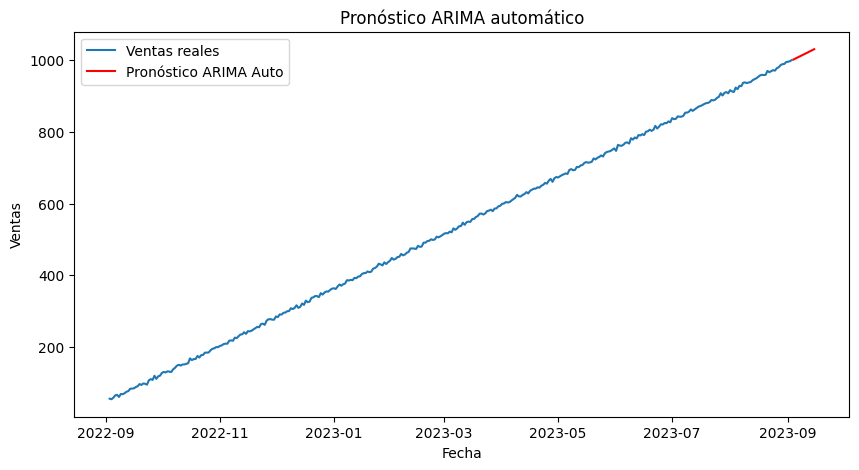

In [7]:
model = auto_arima(df['ventas'], seasonal = True, trace = True, m = 12, stepwise=True, suppress_warnings=True, error_action='ignore')
print(model.summary())

# Predicciones para los próximos 12 periodos
forecast_periods = 12
last_date = df.index[-1]  # ahora sí es datetime
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Generar predicciones
forecast = model.predict(n_periods=forecast_periods)


#Grafico
plt.figure(figsize=(10,5))
plt.plot(df.index, df['ventas'], label='Ventas reales')
plt.plot(forecast_index, forecast, color='red', label='Pronóstico ARIMA Auto')
plt.title("Pronóstico ARIMA automático")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [ ]:
joblib.dump(model, "modelo_arima.pkl")


CONCLUSION

ARIMA encontro los parametros 1,1,1 y realizo la prediccion de las ventas a 12 meses, siendo estas con tendencia positiva.